In [2]:
import json
import urllib
import os
import csv

# 0. Preliminary step to get the dataset




Getting data from sharable google drive folder 

In [ ]:
# link to folder: https://drive.google.com/drive/folders/18TjiltRr8CFlx0aPcLsnKBr5iyeiQxWc?usp=sharing
# upload data folder to your drive root folder 'My Drive' (It is the default folder).

In [3]:
# connect your drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')
# after running this cell, open the url that displays below from your uni gmail account
# copy the code that is displayed 
# paste the code into the cell below when prompted and then press enter

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
folder_path = '/content/drive/My Drive/data_tm_workflow_sample/'

In [5]:
# set the output folder in the drive (the csv files with the results of the process will be downloaded there)
# first create the empty folder in the drive
output_folder = '/content/drive/My Drive/output_tm_mallet_sample/'

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [6]:
import pandas as pd

In [9]:
files_list = os.listdir(folder_path)

In [10]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [11]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open(folder_path + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [12]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

## 1.2. Adding columns for dates, publications and filtering dataset

### 1.2.1. dates, publications




In [13]:
import re

In [14]:
# function to retrieve publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

# function to retrieve day from file name
def get_day(file):
  month_match = re.findall(r'_\d{4}-\d{2}-(\d{2})_',file)
  return month_match[0]

In [15]:
sources['date'] = sources['file_name'].apply(lambda x: get_date(x))
sources['year'] = sources['file_name'].apply(lambda x: get_year(x))
sources['month'] = sources['file_name'].apply(lambda x: get_month(x))
sources['day'] = sources['file_name'].apply(lambda x: get_day(x))
sources['publication'] = sources['file_name'].apply(lambda x: get_ref(x))

In [ ]:
# add publication names

In [16]:
def get_pub_name(pub_number):
    if (pub_number == 'sn85066408'):
        return 'L\'Italia'
    elif (pub_number == '2012271201'):
        return 'Cronaca Sovversiva'

In [17]:
sources['publication_name'] = sources['publication'].apply(lambda x: get_pub_name(x))

### 1.2.2. Filtering

In [18]:
import datetime
from datetime import timedelta, date

In [19]:
# Start from 06.06.1903 and finish 01.05.1919

In [20]:
date_ref_1 = date(1903,6,6)
date_ref_2 = date(1919,5,1)

In [21]:
def filter_by_date(date_item,date_ref_1,date_ref_2):
    year = re.findall(r'(\d{4})-\d{2}-\d{2}',date_item)[0]
    month = re.findall(r'\d{4}-(\d{2})-\d{2}',date_item)[0]
    day = re.findall(r'\d{4}-\d{2}-(\d{2})',date_item)[0]
    file_date = date(int(year),int(month),int(day))
    if (date_ref_1 <= file_date <= date_ref_2):
        return 'included'
    else:
        return 'not included'

In [22]:
sources['status'] = sources['date'].apply(lambda x: filter_by_date(x,date_ref_1,date_ref_2))

In [23]:
sources

,file_name,file_content,date,year,month,day,publication,publication_name,status
0,2012271201_1904-03-26_ed-1_seq-1_ocr.txt,SOVVERSIVA' .MA Ebdomadario anarchico propaga...,1904-03-26,1904,03,26,2012271201,Cronaca Sovversiva,included
1,2012271201_1912-06-15_ed-1_seq-1_ocr.txt,ANNO Per che per chi mandano morire PREZUSE C...,1912-06-15,1912,06,15,2012271201,Cronaca Sovversiva,included
2,2012271201_1905-04-15_ed-1_seq-1_ocr.txt,"ANNO III BARRE VERMONT, SABATO APRILE Num. Sw...",1905-04-15,1905,04,15,2012271201,Cronaca Sovversiva,included
3,2012271201_1905-01-07_ed-1_seq-1_ocr.txt,"ANNO NUMERO SATUIIDAY, JANUARY BAREE, VERMONT...",1905-01-07,1905,01,07,2012271201,Cronaca Sovversiva,included
4,2012271201_1915-09-11_ed-1_seq-1_ocr.txt,"VIVA fra guerrafondai, della gente seria, che...",1915-09-11,1915,09,11,2012271201,Cronaca Sovversiva,included
...,...,...,...,...,...,...,...,...,...
766,2012271201_1904-08-13_ed-1_seq-1_ocr.txt,ANNO (UNION NUMERO GRON SOVVERSIVA Ebdomadari...,1904-08-13,1904,08,13,2012271201,Cronaca Sovversiva,included
767,2012271201_1911-12-16_ed-1_seq-1_ocr.txt,XNNO Poictò tdto noi! 'tf'Z' minatori general...,1911-12-16,1911,12,16,2012271201,Cronaca Sovversiva,included
768,2012271201_1913-02-08_ed-1_seq-1_ocr.txt,ANNO Aldamas condannato processo iniziatosi G...,1913-02-08,1913,02,08,2012271201,Cronaca Sovversiva,included
769,2012271201_1917-01-06_ed-1_seq-1_ocr.txt,Mif f'f WÈÈmm:Amy iWli Li;' moi iONfrmiv SM-:...,1917-01-06,1917,01,06,2012271201,Cronaca Sovversiva,included


In [24]:
# variable containing the documents separately
corpus_df = sources[sources['status'] == 'included'].copy().reset_index()

## 1.2 Removing stop words, punctuation, short words

In [25]:
! pip install nltk

In [26]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
# add tokenized documents in dataframe
corpus_df['tokens'] = corpus_df['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [28]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to remove all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
corpus_df['doc_prep'] = corpus_df['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [ ]:
# link to custom stop words: https://drive.google.com/file/d/1VVfW6AKPbb7_fICOG73lEgkXmmZ6BkpC/view?usp=sharing
# Upload stop words list into Colab files before proceeding with the next cells

In [29]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')
en_stopwords = stopwords.words('english')

In [30]:
stop_words = pd.read_csv('stop_words.csv')

In [31]:
stopwords = stop_words['stopword'].values.tolist()

In [32]:
# add english stop words list to custom stopwords 
stopwords.extend(en_stopwords)

In [ ]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [33]:
# add column with tokenized documents without sw
corpus_df['doc_prep_nostop'] = corpus_df['doc_prep'].apply(lambda x: [w for w in x if not w in stopwords])

In [34]:
corpus_df['doc_prep_nostop']

0      [sovversiva, ebdomadario, anarchico, propagand...
1      [mandano, morire, prezuse, contekioni, felice,...
2      [barre, vermont, sabato, aprile, num, swhvìv, ...
3      [numero, satuiiday, january, baree, vermont, s...
4      [viva, guerrafondai, seria, persuade, tirtei, ...
                             ...                        
766    [union, numero, gron, sovversiva, ebdomadario,...
767    [xnno, poictò, tdto, minatori, campi, antracit...
768    [aldamas, condannato, processo, iniziatosi, ge...
769    [mif, wèèmm, amy, iwli, moi, ionfrmiv, mjèr, c...
770    [numero, ebdomadario, anarchico, propaganda, r...
Name: doc_prep_nostop, Length: 771, dtype: object

In [35]:
# set the variable to use for topic modelling (if no further options are used)
corpus_model = corpus_df['doc_prep_nostop']

In [36]:
# save the data after pre-processing in the output folder for verification of pre-processing steps
# corpus_df.to_csv(output_folder + '/corpus_df.csv')
corpus_df.to_csv(output_folder + '/corpus_df.csv')

## 1.4 Lemmatize

In [ ]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [ ]:
!pip install spacy

In [ ]:
!python3 -m spacy download it_core_news_sm

     |████████████████████████████████| 14.5 MB 1.3 MB/s eta 0:00:01
Using legacy setup.py install for it-core-news-sm, since package 'wheel' is not installed.
    Running setup.py install for it-core-news-sm ... done
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [ ]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [ ]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [ ]:
# takes a long time to run
# add column with lemmatized tokens - directly from the tokens as preprocessing has already been done
corpus_df['doc_lemmatized'] = corpus_df['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [ ]:
# variable with lemmatized tokens
lemmatized_corpus = corpus_df['doc_lemmatized']
# the lemmatized version is not used in this example

# 2. Topics with LDA mallet

In [ ]:
#Gensim installation
! pip install gensim

In [37]:
%%capture
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [38]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [39]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [40]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [41]:
# if you use lemmatized version replace "corpus_model" by lemmatized_corpus
id2word = corpora.Dictionary(corpus_model)
corpus = [id2word.doc2bow(text) for text in corpus_model]

## 2.2 LDA

In [42]:
# set the number of topics here for a first look
numtopics = 7

In [43]:
ldagensim = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [44]:
topic_print = ldagensim.print_topics(num_words=30)

In [45]:
df_topic_print = pd.DataFrame(topic_print, columns=['topic_id','words'])

In [46]:
# df_topic_print.to_csv(output_folder + '/init_topics.csv')
df_topic_print.to_csv(output_folder + '/init_topics_mallet.csv')

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [47]:
from gensim.models.coherencemodel import CoherenceModel

In [48]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=corpus_model, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()

In [49]:
print('\nCoherence Score LDA Mallet: ', coherence_ldagensim)


Coherence Score LDA Mallet:  0.4152698197849197


## 2.4 Coherence and number of topics

In [ ]:
# as coherence calculation can take quite some time to run (depending on number of documents), I removed the accuracy parameters for performance reasons 
# it's normal that the coherence is then lower than what was found earlier, as the parameters
# give less accurate results

In [50]:
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(3, 20):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=corpus_model, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [57]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 3  has Coherence Value of 0.3795
Num Topics = 4  has Coherence Value of 0.4188
Num Topics = 5  has Coherence Value of 0.3997
Num Topics = 6  has Coherence Value of 0.4115
Num Topics = 7  has Coherence Value of 0.4004
Num Topics = 8  has Coherence Value of 0.419
Num Topics = 9  has Coherence Value of 0.4173
Num Topics = 10  has Coherence Value of 0.4054
Num Topics = 11  has Coherence Value of 0.4243
Num Topics = 12  has Coherence Value of 0.4261
Num Topics = 13  has Coherence Value of 0.4584
Num Topics = 14  has Coherence Value of 0.4599
Num Topics = 15  has Coherence Value of 0.4256
Num Topics = 16  has Coherence Value of 0.4422
Num Topics = 17  has Coherence Value of 0.4509
Num Topics = 18  has Coherence Value of 0.4573
Num Topics = 19  has Coherence Value of 0.4515


In [52]:
df_coherence = pd.DataFrame(topics_nr, columns=['topic_id'])

In [53]:
df_coherence['topic_coherence'] = coherence_values_gensim

In [54]:
# df_coherence.to_csv(output_folder +'/coherence_values.csv')
df_coherence.to_csv(output_folder + '/coherence_values.csv')

In [55]:
# Visualize coherence scores
import matplotlib.pyplot as plt

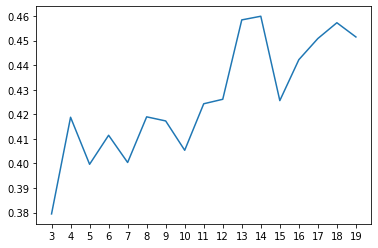

In [56]:
plt.plot(topics_nr, coherence_values_gensim)

In [ ]:
# To analyse the results, the user can print the list of topics for different topic nr

In [58]:
# print topics for nr of topics = 15 - I put here parameters for better accuracy as this will be 
# the model used to do the rest of calculations - takes approx 15min to run
numtopics = 14
#model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=numtopics, chunksize = 100, passes = 10, eval_every = None)
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus, id2word=id2word, num_topics=numtopics)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [59]:
topic_print_advanced_options = model.print_topics(num_words=30)

In [60]:
df_topic_print_advanced_options = pd.DataFrame(topic_print_advanced_options, columns=['topic_id','words'])

In [61]:
df_topic_print_advanced_options.to_csv(output_folder +'/14_topics.csv')

# Topic visualisation

## Data Preparation

In [62]:
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py

--2020-07-16 10:21:07--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219774 (215K) [text/plain]
Saving to: ‘jscode-test-2.js’

jscode-test-2.js    100%[===================>] 214.62K  --.-KB/s    in 0.03s   

2020-07-16 10:21:07 (6.67 MB/s) - ‘jscode-test-2.js’ saved [219774/219774]

--2020-07-16 10:21:08--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awa

In [63]:
%%capture
!pip install funcy

In [64]:
%run -i tm1_data_prepare_gensim

<Figure size 432x288 with 0 Axes>

In [65]:
# retranslate mallet into gensim
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)

In [66]:
data_vis = prepare(model, corpus, id2word, doc_topic_dist=None)

In [67]:
topic_info = data_vis[1][data_vis[1]['Category'] == 'Default'].copy()

In [68]:
topic_info['relevance'] = ''

In [69]:
for i in range(numtopics):
  topic_num = i+1
  data = data_vis.sorted_terms(topic=topic_num, _lambda=.6).copy()
  topic_info = topic_info.append(data)

In [ ]:
# uncomment to show the full output of a topic, replace 'Topic8' by the topic to display
# topic_info[topic_info['Category'] == 'Topic8']

In [70]:
topic_info.to_csv(output_folder + '/topic_info.csv')

In [71]:
topic_proportion = data_vis[0].copy()

In [72]:
topic_proportion['proportion'] = topic_proportion['Freq'] / 100

In [73]:
topic_proportion.index.name = 'topic_id'

In [74]:
topic_proportion.to_csv(output_folder + '/topic_proportion.csv')

In [75]:
# download also in Jupyter environment for further processing
topic_info.to_csv('topic_info.csv')
topic_proportion.to_csv('topic_proportion.csv')

In [76]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

## Visualisation

In [77]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [78]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [79]:
%%capture
ldamodel = model

In [80]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [81]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [82]:
distribution_gensim.index.name = 'document'

In [83]:
# add file names and publication name
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', corpus_df['file_name'])
distribution_gensim_wfiles.insert(1, 'publication_name', corpus_df['publication_name'])
distribution_gensim_wfiles

,document_path,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13
document,,,,,,,,,,,,,,,,
0,2012271201_1904-03-26_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.029421,0.033995,0.118510,0.056554,0.017329,0.045904,0.155744,0.031082,0.029615,0.252295,0.145132,0.032811,0.008017,0.043590
1,2012271201_1912-06-15_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.079753,0.040495,0.049101,0.174670,0.028722,0.026142,0.130765,0.088964,0.083195,0.013106,0.200473,0.055667,0.008448,0.020499
2,2012271201_1905-04-15_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.021137,0.168584,0.036082,0.021668,0.006490,0.077188,0.180507,0.050619,0.029742,0.158386,0.055227,0.151114,0.023458,0.019800
3,2012271201_1905-01-07_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.086741,0.044169,0.083129,0.027278,0.047181,0.071954,0.038528,0.055107,0.131232,0.053534,0.091506,0.175372,0.063823,0.030446
4,2012271201_1915-09-11_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.157751,0.011680,0.302784,0.131689,0.062717,0.030272,0.024513,0.019121,0.171963,0.010902,0.015390,0.016754,0.026542,0.017921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2012271201_1904-08-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.036858,0.070507,0.013634,0.036481,0.067417,0.014100,0.183124,0.090149,0.014858,0.271791,0.066855,0.045065,0.066002,0.023159
767,2012271201_1911-12-16_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.059796,0.107486,0.012097,0.075399,0.018613,0.142535,0.211355,0.035228,0.008219,0.045630,0.072456,0.053714,0.008355,0.149117
768,2012271201_1913-02-08_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.051218,0.043303,0.044998,0.025187,0.324325,0.017653,0.035837,0.052656,0.168800,0.007221,0.034044,0.034807,0.024544,0.135408


## 3.2. Distribution per topic for the whole corpus

In [84]:
corpus_df['doc_length'] = corpus_df['doc_prep_nostop'].apply(lambda x: len(x))

In [85]:
topic_frequency = distribution_gensim.mul(corpus_df['doc_length'], axis=0).sum()

In [86]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [87]:
topic_proportion

topic6     10.161340
topic8      8.874731
topic2      8.624171
topic3      7.754587
topic1      7.566572
topic11     7.308590
topic7      7.067110
topic9      7.054163
topic10     6.718895
topic0      6.586291
topic13     5.636546
topic5      5.575392
topic4      5.562469
topic12     5.509143
dtype: float64

In [88]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [89]:
distribution_df_gensim.index.name = "topics"

In [90]:
distribution_df_gensim.to_csv(output_folder + '/topic_distribution.csv')

In [91]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

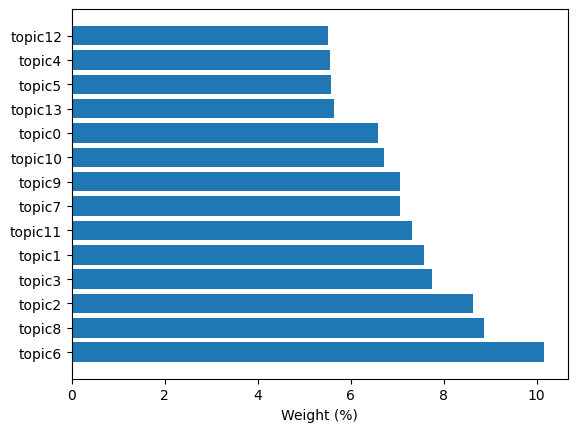

In [92]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

### 3.3. Distribution per publication


In [93]:
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [94]:
gensim_groupby2 = distribution_gensim_wfiles.copy()

In [95]:
distribution_title = gensim_groupby2.groupby(['publication_name']).mean().reset_index()
#distribution_title['publication'] = distribution_title['publication'].apply(lambda x: get_pub_name(x))

In [96]:
distribution_title

,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13
0,Cronaca Sovversiva,0.062015,0.074816,0.084281,0.07116,0.052829,0.057616,0.103543,0.069708,0.087681,0.081731,0.069194,0.076857,0.052992,0.055575


In [97]:
distribution_title.to_csv(output_folder + '/distribution_per_publication.csv')

In [98]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication_name'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

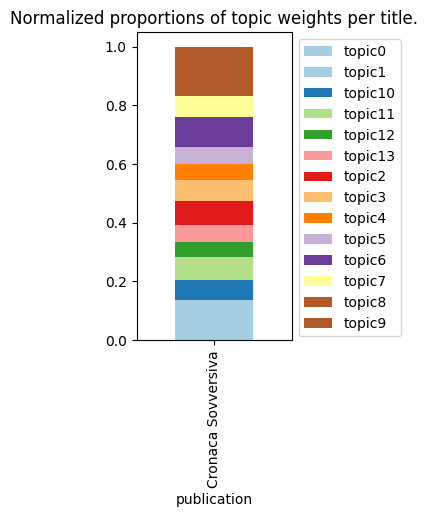

In [99]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time

## 4.1 Aggregate document weights

In [ ]:
# grouping data per month

In [100]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [101]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [102]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [103]:
# group by year 
distribution_year = gensim_groupby.groupby(['year']).mean().reset_index()

In [104]:
distribution_year

,year,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13
0,1903,0.040769,0.034486,0.074559,0.020254,0.021890,0.075565,0.103280,0.053521,0.078374,0.246867,0.133408,0.047504,0.028778,0.040744
1,1904,0.036343,0.051587,0.079145,0.027528,0.023135,0.050801,0.100938,0.065186,0.067062,0.212748,0.094458,0.089598,0.036690,0.064782
2,1905,0.035340,0.083558,0.060739,0.024746,0.025895,0.083440,0.128205,0.064675,0.083360,0.141642,0.072556,0.130678,0.027678,0.037487
3,1906,0.029441,0.087996,0.040428,0.023265,0.021871,0.066684,0.157842,0.063311,0.060988,0.146175,0.076660,0.150288,0.024463,0.050587
4,1907,0.039753,0.100141,0.057214,0.024338,0.042578,0.065079,0.109947,0.064914,0.081809,0.141113,0.079025,0.084364,0.054456,0.055270
5,1908,0.051229,0.086497,0.069260,0.023629,0.051124,0.060798,0.077709,0.074167,0.084367,0.106921,0.061785,0.083004,0.115825,0.053684
6,1909,0.058079,0.080387,0.084408,0.023042,0.035185,0.053399,0.084580,0.093674,0.116537,0.063486,0.073442,0.083965,0.105283,0.044533
7,1910,0.062953,0.141271,0.051812,0.033838,0.033759,0.061938,0.111948,0.074530,0.076305,0.038428,0.059649,0.093398,0.092730,0.067440
8,1911,0.039727,0.165333,0.052512,0.052122,0.025995,0.067435,0.142468,0.091187,0.093024,0.043838,0.057339,0.076388,0.052707,0.039924
9,1912,0.059703,0.067728,0.090424,0.076657,0.110275,0.040115,0.090995,0.111210,0.110059,0.033234,0.061301,0.045842,0.038915,0.063543


In [105]:
distribution_year.to_csv(output_folder + '/distribution_per_year.csv')

## 4.2 Monthly average of normalized weight per topic

### 4.2.1. Line chart view 

In [106]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_year.columns)-2
for i in range(len(distribution_year)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_year['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_year.columns[j+1]
    df_vis['distribution'].loc[x] = distribution_year.iloc[i,(j+1)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


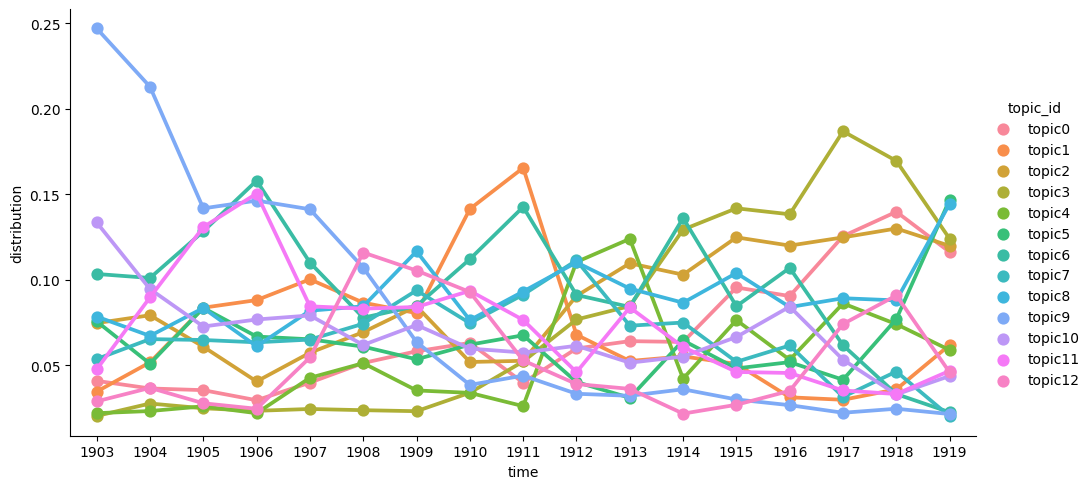

In [107]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.2. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


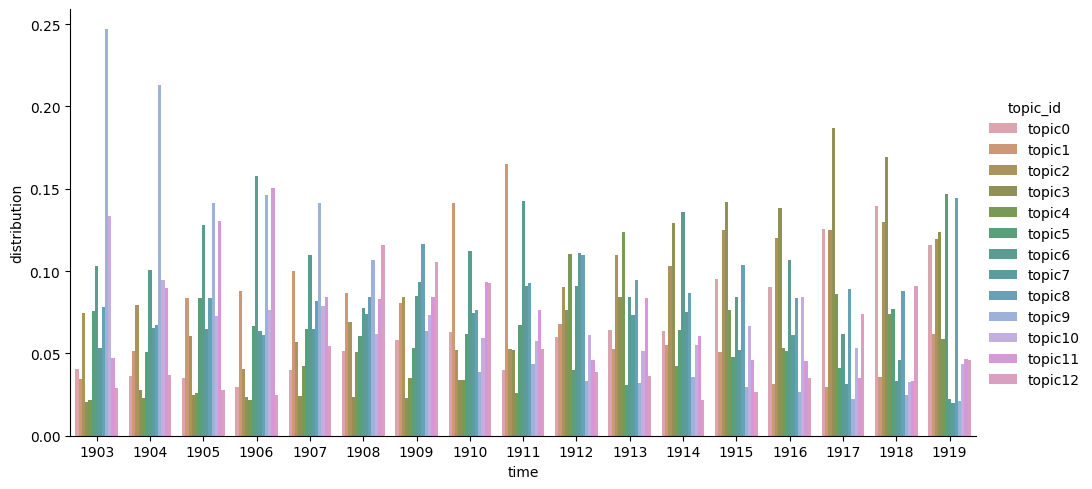

In [108]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Topic weights per title over time



In [109]:
gensim_groupby3 = distribution_gensim_wfiles.copy()

In [110]:
distribution_title_time = gensim_groupby3.groupby(['year','publication_name']).mean().reset_index()

In [111]:
distribution_title_time

,year,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13
0,1903,Cronaca Sovversiva,0.040769,0.034486,0.074559,0.020254,0.021890,0.075565,0.103280,0.053521,0.078374,0.246867,0.133408,0.047504,0.028778,0.040744
1,1904,Cronaca Sovversiva,0.036343,0.051587,0.079145,0.027528,0.023135,0.050801,0.100938,0.065186,0.067062,0.212748,0.094458,0.089598,0.036690,0.064782
2,1905,Cronaca Sovversiva,0.035340,0.083558,0.060739,0.024746,0.025895,0.083440,0.128205,0.064675,0.083360,0.141642,0.072556,0.130678,0.027678,0.037487
3,1906,Cronaca Sovversiva,0.029441,0.087996,0.040428,0.023265,0.021871,0.066684,0.157842,0.063311,0.060988,0.146175,0.076660,0.150288,0.024463,0.050587
4,1907,Cronaca Sovversiva,0.039753,0.100141,0.057214,0.024338,0.042578,0.065079,0.109947,0.064914,0.081809,0.141113,0.079025,0.084364,0.054456,0.055270
5,1908,Cronaca Sovversiva,0.051229,0.086497,0.069260,0.023629,0.051124,0.060798,0.077709,0.074167,0.084367,0.106921,0.061785,0.083004,0.115825,0.053684
6,1909,Cronaca Sovversiva,0.058079,0.080387,0.084408,0.023042,0.035185,0.053399,0.084580,0.093674,0.116537,0.063486,0.073442,0.083965,0.105283,0.044533
7,1910,Cronaca Sovversiva,0.062953,0.141271,0.051812,0.033838,0.033759,0.061938,0.111948,0.074530,0.076305,0.038428,0.059649,0.093398,0.092730,0.067440
8,1911,Cronaca Sovversiva,0.039727,0.165333,0.052512,0.052122,0.025995,0.067435,0.142468,0.091187,0.093024,0.043838,0.057339,0.076388,0.052707,0.039924
9,1912,Cronaca Sovversiva,0.059703,0.067728,0.090424,0.076657,0.110275,0.040115,0.090995,0.111210,0.110059,0.033234,0.061301,0.045842,0.038915,0.063543


In [112]:
distribution_title_time.to_csv(output_folder + 'distribution_per_publication_over_time.csv')

### 4.2.4. Rolling average

#### 4.2.4.1. Rolling average by topic

In [113]:
rolling_mean = distribution_year.rolling(2).mean()

In [114]:
rolling_mean.to_csv(output_folder + 'rolling_mean.csv')

In [115]:
#restructuring df so that it can work with seaborn
df_vis3 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean.columns)-2
for i in range(len(rolling_mean)):
  for j in range(columns_nr):
    if ( rolling_mean.iloc[i,(j+1)] > 0 ):
      df_vis3.loc[x] = ''
      df_vis3['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis3['topic_id'].loc[x] = rolling_mean.columns[j+1]
      df_vis3['rolling_mean'].loc[x] = rolling_mean.iloc[i,(j+1)]
      x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


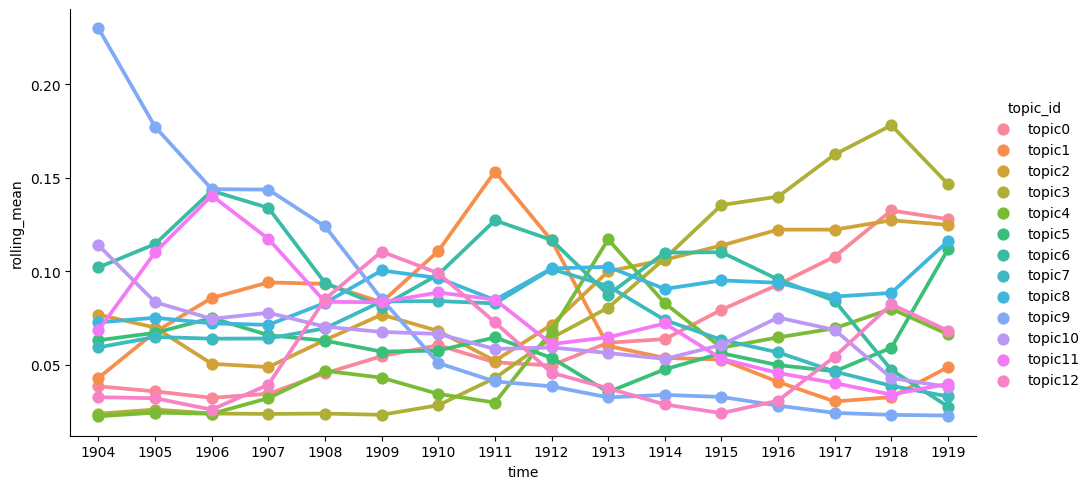

In [116]:
sns.factorplot(data= df_vis3, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)